2280
False
Epoch: 1, Loss: 203012.78125
Epoch: 3, Loss: 186889.31250
Epoch: 5, Loss: 115145.88281
Epoch: 7, Loss: 44805.77734
Epoch: 9, Loss: 70394.14844
Epoch: 11, Loss: 40005.33984
Epoch: 13, Loss: 52219.47266
Epoch: 15, Loss: 55287.10547
Epoch: 17, Loss: 44843.50781
Epoch: 19, Loss: 38784.14453
Epoch: 21, Loss: 45572.26562
Epoch: 23, Loss: 43341.48047
Epoch: 25, Loss: 38287.89062
Epoch: 27, Loss: 40645.06641
Epoch: 29, Loss: 41858.56641
Epoch: 31, Loss: 39170.87891
Epoch: 33, Loss: 38233.76953
Epoch: 35, Loss: 39734.04688
Epoch: 37, Loss: 38527.38281
Epoch: 39, Loss: 37897.98438
Epoch: 41, Loss: 38582.38672
Epoch: 43, Loss: 38308.90234
Epoch: 45, Loss: 37770.56641
Epoch: 47, Loss: 38161.88672
Epoch: 49, Loss: 37899.08984
Epoch: 51, Loss: 37724.44531
Epoch: 53, Loss: 37882.39844
Epoch: 55, Loss: 37755.72656
Epoch: 57, Loss: 37654.71875
Epoch: 59, Loss: 37731.87500
Epoch: 61, Loss: 37602.01953
Epoch: 63, Loss: 37523.63672
Epoch: 65, Loss: 37481.73047
Epoch: 67, Loss: 37408.35547
Epoch

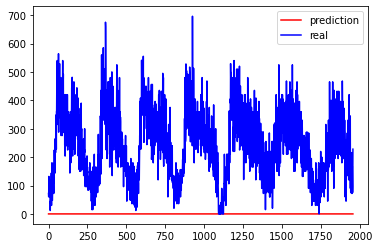

In [9]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import time 
import numpy as np

# --------------------------------（常量定义）------------------------------

time_steps = 24 # ~ 2小时
epoch = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------------------------------（工具方法）------------------------------

# 保存模型到本地
def save_checkpoint(epoch, 
                    model, 
                    lossMIN, 
                    optimizer, 
                    checkpoint_path):
    return
    launchTimestamp = str(time.time())
    torch.save({'epoch': epoch + 1, 
                'state_dict': model.state_dict(), 
                'best_loss': lossMIN,
                'optimizer': optimizer.state_dict()
               }, 
               checkpoint_path + '/m-' + launchTimestamp + '-' + str("%.4f" % lossMIN) + '.pth.tar')

# 从本地加载模型
def load_checkpoint(model, checkpoint_PATH, optimizer):
    if checkpoint != None:
        model_CKPT = torch.load(checkpoint_PATH)
        model.load_state_dict(model_CKPT['state_dict'])
        print('loading checkpoint!')
        optimizer.load_state_dict(model_CKPT['optimizer'])
    return model, optimizer

    
# ------------------------------- （LSTM 模型）---------------------------------------

# 加载数据集
def load_data(path, np_type=True):
    data_csv = pd.read_csv(path, usecols=[2])
    data_csv = data_csv.dropna()
    dataset = data_csv.values
    dataset = dataset.astype('float32')
    x, y = split_data(dataset,np_type)
    return x, y

def split_data(dataset,np_type=True):
    dataX, dataY = [], []
    lens = len(dataset)    
    for i in range(lens - time_steps):
        dataX.append(dataset[i: i + time_steps])
        dataY.append(dataset[i + time_steps])
    dataX = np.array(dataX).reshape(-1, time_steps)
    dataY = np.array(dataY)
    return dataX, dataY

def get_batchs_for_lstm(x):
    return x.t().view(time_steps,-1,1)

class TrafficDataset(Dataset):
    def __init__(self,filepath):
        train_x, train_y = load_data(filepath)
        var_x = torch.tensor(train_x, dtype=torch.float32, device=device)
        var_y = torch.tensor(train_y, dtype=torch.float32, device=device)
        self.x = var_x
        self.y = var_y
        self.len = train_y.shape[0]
        print(self.len)
   
    def __getitem__(self,index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.len

# lstm 模型
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers) # rnn
        self.reg = nn.Linear(hidden_size * time_steps, 1024) # 回归
        self.reg2 = nn.Linear(1024, output_size) # 回归
        self.activate = nn.ReLU()
        
    def forward(self, x):
        x, _ = self.rnn(x) # (seq, batch, hidden)
        s, b, h = x.shape
        x = x.view(b, s*h) # 转换成线性层的输入格式 
        x = self.reg(x)
        x = self.activate(x)
        x = self.reg2(x)
        return x

# ------------------------------- （LSTM训练）---------------------------------------

def test_net(net):
    net.eval()
    test_x, test_y = load_data('~/16-5m.csv')
    test_x = test_x[0,:]
    result_y = []
    
    for i in range(0, test_y.shape[0]):
        var_x = torch.tensor(test_x, dtype=torch.float32, device=device)
        var_x = get_batchs_for_lstm(var_x)
        pred_y = net(var_x).cpu()
        pred_y_num = pred_y.view(-1).data.numpy().tolist()[0]
        test_x = test_x.tolist()
        test_x.append(pred_y_num)
        result_y.append(pred_y_num)
        test_x = test_x[1:] #后移一格，24步预测后一步
        test_x = np.array(test_x)
        
    plt.plot(result_y, 'r', label='prediction')
    plt.plot(test_y, 'b', label='real')
    plt.legend(loc='best')

# 集成学习
class Ess_net(nn.Module):
    
    def __init__(self):
        super(Ess_net, self).__init__()
        self.net1 = lstm_reg(1,64)
        self.net2 = lstm_reg(1,32)
        self.net3 = lstm_reg(1,16)
        self.linear1 = nn.Linear(3, 1)
        
    def forward(self, x):
        y1 = self.net1(x).view(-1)
        y2 = self.net2(x).view(-1)
        y3 = self.net3(x).view(-1)
        z = torch.stack((y1,y2,y3), dim=0).T
        r = self.linear1(z)
        return r
    
def train_lstm():
    dataset = TrafficDataset('~/15-5m.csv')
    print(torch.cuda.is_available())
    net = lstm_reg(1, 64).to(device)
    ess_net = Ess_net()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(ess_net.parameters(), lr=1e-2)
    train_loader = DataLoader(dataset=dataset, 
                          batch_size=2280,
                          shuffle=False,
                          num_workers=0)
    
    for e in range(epoch):
        hadFound = False
        for i, data in enumerate(train_loader, 0):
            # 前向传播
            var_x, var_y = data
            var_x = get_batchs_for_lstm(var_x)            
            out = ess_net(var_x)
            loss = criterion(out, var_y)
            # 反向传播
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_num = loss.data.item()
            
            if e % 2 == 0:
                print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.data.item()))
            
            if e % 1000 == 0:
                save_checkpoint(epoch,
                        net,
                        loss_num,
                        optimizer,
                        '/')
                
            if loss.data.item() < 0.2:
                print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.data.item()))
                print('finfished..,')
                save_checkpoint(epoch,
                        net,
                        loss_num,
                        optimizer,
                        '/')
                hadFound = True
                break
        if hadFound:
            break
    return net

result_net = train_lstm()
test_net(result_net)
